# Calculate the $O_2$ and $\delta(O_2/N_2)$ baselines

In [1]:
import os
import glob

from acrg.name.name import open_ds

## Set up information

Information to be used throughout the notebook

Reference values are taken from Rodenbeck et al., 2008:

$X_0^{CO_2} = 350$ \
$X_0^{N_2} = 790190$ \
$X_0^{O_2} = 209460$

In [2]:
site = 'WAO'
year = 2018

ref_values = {'co2': 350, 'n2': 790190, 'o2': 209460}
ref_values['o2_n2'] = ref_values['o2'] / ref_values['n2']

## Get the data

Find the APO and CO2 timeseries files and open

In [3]:
ts_files = glob.glob(os.path.join('/user', 'work', 'vf20487', 'Timeseries', 'o2_co2', f'{site}_bc_timeseries_{year}.nc'))[0]
ts_data = open_ds(ts_files)

print(ts_files)
print([dv for dv in ts_data.data_vars])

/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2018.nc
['apo', 'co2', 'delta_o2_n2', 'o2']


## Convert the APO units

The APO timeseries should be in per meg units

Check that the numbers look right for these units, and convert if not.\
They should be ~350

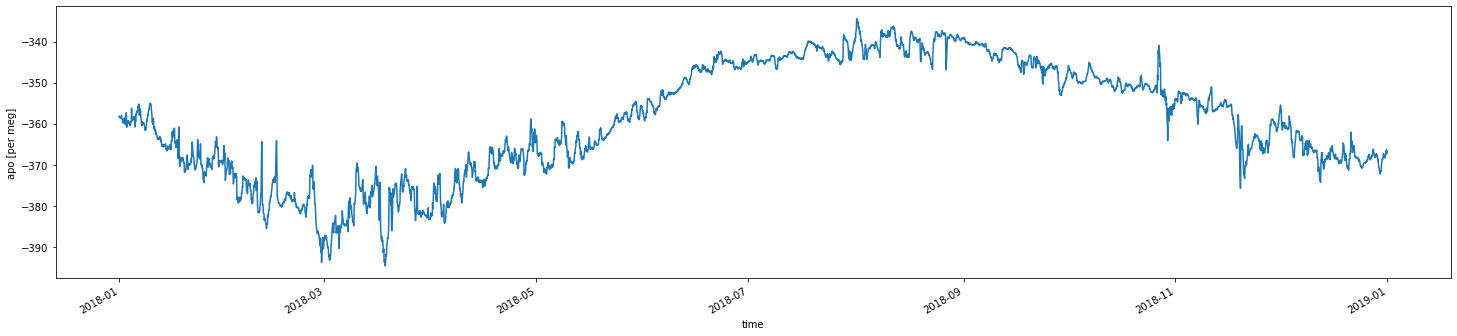

In [4]:
# apo units should be per meg, convert if it is in ppm
ts_data['apo'] = ts_data.apo * 1e-6 if (abs(ts_data.apo)>1e7).all() else ts_data.apo
ts_data['apo'] = ts_data.apo / 0.20946 if all(abs(ts_data.apo)<100) else ts_data.apo
# make sure the sign of the baseline is correct
ts_data['apo'] = -ts_data.apo if all(ts_data.fillna(1).apo>0) else ts_data.apo

apo_plot = ts_data.apo.plot(figsize=(25, 5))

## Calculate the O2

1. Use the APO equation to calculate $\delta(O_2/N_2)$:

$APO = \delta(O_2/N_2) + 1.1 / X_0^{O_2} \times (CO_2 - X_0^{CO_2}) \times 10^6$



2. Then use the $\delta(O_2/N_2)$ to calculate O_2:

$\delta(O_2/N_2) = \frac{(O_2/N_2)_{sample} - (O_2/N_2)_{ref}}{(O_2/N_2)_{ref}} \times 10^6$

['apo', 'co2', 'delta_o2_n2', 'o2', 'o2_n2']


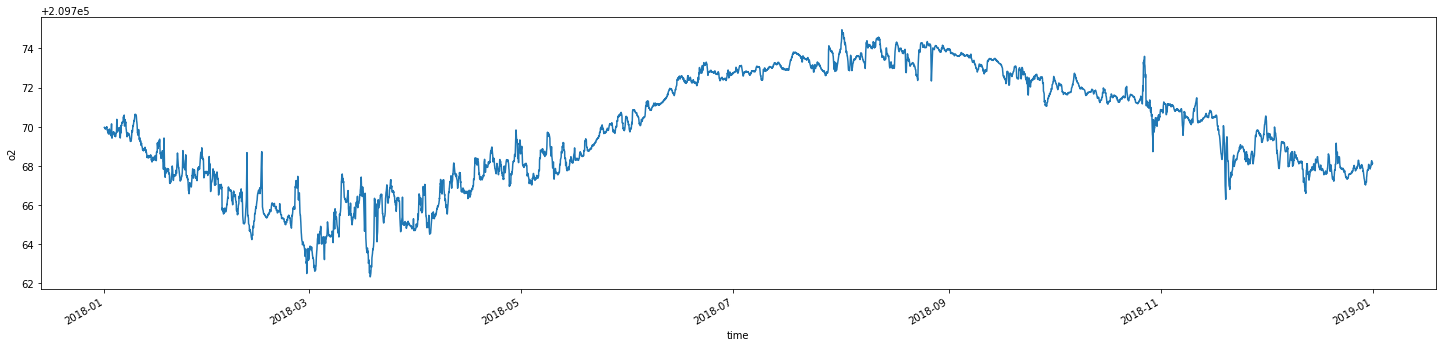

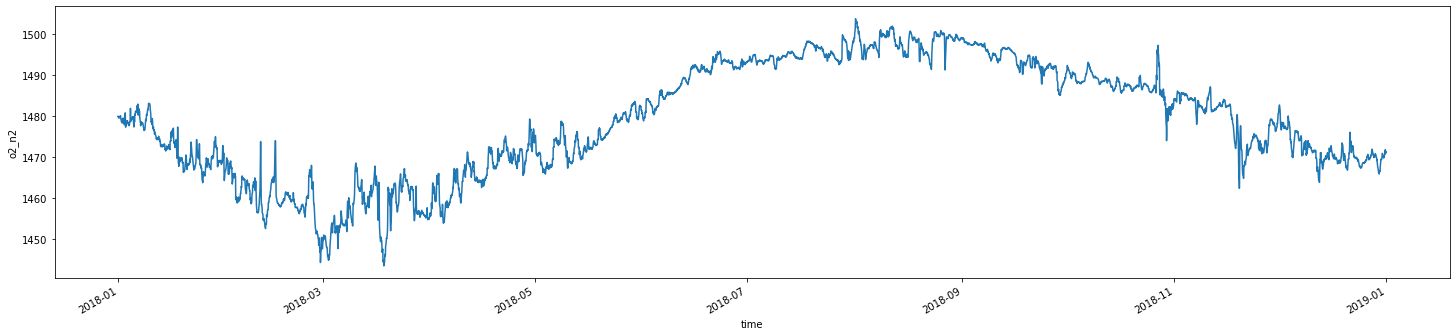

In [5]:
per_meg_conversion = 1e6 / ref_values['o2']
ts_data['o2_n2'] = ts_data.apo - 1.1 * per_meg_conversion * (ts_data.co2 - ref_values['co2'])
ts_data['o2'] = (ts_data.o2_n2 * ref_values['o2_n2'] * 1e-6 + ref_values['o2_n2']) * ref_values['n2']

print([dv for dv in ts_data.data_vars])

o2_plot = ts_data.o2.plot(figsize=(25, 5))
o2_n2_plot = ts_data.o2_n2.plot(figsize=(25, 5))

In [22]:
for dv in ts_data.data_vars:
    unit = 'ppm' if dv in ['co2', 'o2'] else 'per meg'
    spec = 'o2/n2' if dv=='o2_n2' else dv
    attr = {'description': f'modelled boundary condition contribution to the mole fraction of {spec}',
            'units': unit}
    ts_data[dv] = ts_data[dv].assign_attrs(attr)


## Save to netcdf

Open the file containing all APO component timeseries and save the oxygen and $\delta(O_2/N_2)$ baselines to it

In [23]:
print(f'Adding oxygen timeseries to file: {ts_files}')
ts_data.to_netcdf(ts_files)


Adding oxygen timeseries to file: /user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2018.nc
